# Importando bibliotecas

In [ ]:
import logging
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import MlpPolicy
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import time
from datetime import datetime
from torch import nn  # Import the neural network module from PyTorch
import gym
from gym import spaces
from sklearn.model_selection import train_test_split
from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from sklearn.utils import resample
import sys
import os
sys.path.append(os.path.join('..'))
from classes._exploration import exploration
from classes._Env3WGym import Env3WGym
from classes._LoadInstances import LoadInstances
from classes._Agent import Agent
from classes._Supervised import Supervised
from classes._ValidationModel import ValidationModel

In [ ]:
if __name__ == '__main__':

    events_names = {
        # 0: 'Normal',
        1: 'Abrupt Increase of BSW',
        # 2: 'Spurious Closure of DHSV',
        # 3: 'Severe Slugging',
        # 4: 'Flow Instability',
        # 5: 'Rapid Productivity Loss',
        # 6: 'Quick Restriction in PCK',
        # 7: 'Scaling in PCK',
        # 8: 'Hydrate in Production Line'
    }

    event_name = [value for key, value in events_names.items() if key != 0][0]
    
    models = ['DQN'] # 'DQN' or 'PPO', 'RNA' 
    
    for model_type in models:
        for event_name in [value for key, value in events_names.items() if key != 0]:

            directory = f'..\\..\\logs\\{event_name}'
            path_dataset = '..\\..\\..\\dataset'   
            path_model = f'..\\models\\{event_name}\\{model_type}'  

            if not os.path.exists(directory):
                os.makedirs(directory)
            
            if not os.path.exists(path_model):
                os.makedirs(path_model)                
            
                    
            current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            log_filename = f'{directory}\\{current_time}_{event_name}_{model_type}-log.txt'
            # Configuração do Logging
            logging.basicConfig(filename=log_filename, filemode='w', level=logging.INFO, format='[%(levelname)s]\t%(asctime)s - %(message)s', datefmt='%d/%m/%Y %I:%M:%S %p', force=True, encoding='utf-8')

            instances = LoadInstances(path_dataset)
            
            logging.info(f'Iniciando carregamento do dataset')
            dataset = instances.load_instance_with_numpy(events_names)    
            logging.info(f'Fim carregamento do dataset')
            
            logging.info(f'Iniciando divisão do dataset em treino e teste')
                
            # Definindo a porcentagem para divisão entre treino e teste
            train_percentage = 0.8  # 80% para treino

            dataset_train_scaled, dataset_test_scaled, dataset_validation_scaled = instances.data_preparation(dataset, train_percentage)

            if model_type == 'DQN':
                logging.info(f'Iniciando treinamento do algoritmo DQN')    
                start_time = time.time()
                agente = Agent(path_model)
                agente.env3W_dqn(dataset_train_scaled, n_envs = 5)  
                print(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
                logging.info(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
                logging.info(f'Fim treinamento do algoritmo DQN')


                logging.info(f'Iniciando avaliação do algoritmo DQN conjunto de teste')
                accuracy, model_agent = agente.env3W_dqn_eval(dataset_test_scaled, n_envs = 1)
                print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando DQN')
                logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando DQN')
                logging.info(f'Fim avaliação  do algoritmo DQN conjunto de teste')
                
            elif model_type == 'PPO':      
            
                start_time = time.time()
                agente = Agent(path_model)
                agente.env3W_ppo(dataset_train_scaled, n_envs = 5)  
                print(f"Tempo de Treinamento {model}: {round(time.time() - start_time, 2)}s")
                logging.info(f"Tempo de Treinamento {model}: {round(time.time() - start_time, 2)}s")
                logging.info(f'Fim treinamento do algoritmo {model}')

                logging.info(f'Iniciando avaliação do algoritmo {model} conjunto de teste')
                accuracy, model_agent = agente.env3W_ppo_eval(dataset_test_scaled, n_envs = 1)
                print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando {model}')
                logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando {model}')
                logging.info(f'Fim avaliação  do algoritmo PPO conjunto de teste')
            
            elif model_type == 'RNA':
                logging.info(f'Iniciando treinamento do modelo RNA')  
                
                supervised = Supervised(path_model, dataset_train_scaled, dataset_test_scaled)
                start_time = time.time()
                model_agent = supervised.keras_train()  
                print(f"Tempo de Treinamento RNA: {round(time.time() - start_time, 2)}s")
                logging.info(f"Tempo de Treinamento RNA: {round(time.time() - start_time, 2)}s")
                logging.info(f'Fim treinamento do modelo RNA')

                logging.info(f'Iniciando avaliação do modelo RNA conjunto de teste')
                accuracy = supervised.keras_evaluate()
                print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando RNA')
                logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando RNA')
                logging.info(f'Fim avaliação  do modelo RNA conjunto de teste')

            logging.info(f'Iniciando a validação do modelo {model_type}') 
            validation = ValidationModel(model_type, event_name)

            validation.validation_model(accuracy, dataset_validation_scaled, model_agent)

            logging.info(f'Concluído a execução do algoritmo {model_type} para o evento {event_name}')
   

### Testando novo modelo de ambiente para detecção de Aumento Abrupto de BSW

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sys
import os
import time
from datetime import datetime
import numpy as np
import logging
sys.path.append(os.path.join('..'))
from classes._Env3WGym_copy import Env3WGym
from classes._LoadInstances import LoadInstances
from classes._Agent_copy import Agent
from classes._ValidationModel import ValidationModel

if __name__ == '__main__':
    events_names = {
            # 0: 'Normal',
            1: 'Abrupt Increase of BSW',
            # 2: 'Spurious Closure of DHSV',
            # 3: 'Severe Slugging',
            # 4: 'Flow Instability',
            # 5: 'Rapid Productivity Loss',
            # 6: 'Quick Restriction in PCK',
            # 7: 'Scaling in PCK',
            # 8: 'Hydrate in Production Line'
        }


    event_name = [value for key, value in events_names.items() if key != 0][0]  

    models = ['DQN'] # 'DQN' or 'PPO'
    directory = f'..\\..\\logs\\{event_name}'
    path_dataset = '..\\..\\..\\dataset' 

    for model_type in models:
        path_model = f'..\\models\\{event_name}\\{model_type}'  

        if not os.path.exists(directory):
            os.makedirs(directory)

        if not os.path.exists(path_model):
            os.makedirs(path_model) 

        current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        log_filename = f'{directory}\\{current_time}_{event_name}_{model_type}-log.txt'
        # Configuração do Logging
        logging.basicConfig(filename=log_filename, filemode='w', level=logging.INFO, format='[%(levelname)s]\t%(asctime)s - %(message)s', datefmt='%d/%m/%Y %I:%M:%S %p', force=True, encoding='utf-8')

        instances = LoadInstances(path_dataset)

        _, array_list = instances.load_instance_with_numpy(events_names, type_instance='simulated')

        # Normalizar características excluindo timestamp (primeira coluna) e rótulos (última coluna)
        features_list = [arr[:, 1:-1].astype(float) for arr in array_list]  # Exclui timestamp e rótulo
        scaler = StandardScaler().fit(np.concatenate(features_list, axis=0))
        features_scaled_list = [scaler.transform(features) for features in features_list]

        # Reconstituir arrays incluindo timestamp, características normalizadas e rótulos
        array_list_reconstituted = [np.column_stack((arr[:, 0], features_scaled, arr[:, -1]))
                                    for arr, features_scaled in zip(array_list, features_scaled_list)]

        # Divisão dos dados
        train_data, test_valid_data = train_test_split(array_list_reconstituted, test_size=0.2, random_state=42)
        test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state=42)


        # Por exemplo, para excluir os timestamps e rótulos antes do treinamento, você pode fazer:
        train_data = [data[:, 1:-1] for data in train_data]  # Exclui a primeira coluna (timestamp) e a última (rótulo)

        test_data = [data[:, 1:-1] for data in test_data]  # Exclui a primeira coluna (timestamp) e a última (rótulo)

        agente = Agent('..\\models\\' + event_name)

        if model_type == 'DQN':
            # Treinamento com DQN
            start_time = time.time()
            agente.env3W_dqn(train_data, n_envs=5)
            print(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
            logging.info(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")

            # Avaliação com DQN usando o conjunto de teste
            accuracy, model_agent = agente.env3W_dqn_eval(test_data, n_envs=1)
            print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando DQN')
            logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando DQN')
        elif model_type == 'PPO':

            # Treinamento com PPO
            start_time = time.time()
            agente.env3W_ppo(train_data, n_envs=5)
            print(f"Tempo de Treinamento PPO: {round(time.time() - start_time, 2)}s")
            logging.info(f"Tempo de Treinamento PPO: {round(time.time() - start_time, 2)}s")

            # Avaliação com PPO usando o conjunto de teste
            accuracy, model_agent = agente.env3W_ppo_eval(test_data, n_envs=1)
            print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando PPO')
            logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando PPO')

        validation = ValidationModel(model_type, event_name)

        validation.validation_model(accuracy, valid_data, model_agent, type_ml='RL')

c:\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Tempo de Treinamento DQN: 28.73s


c:\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Acurácia de 29.64% no conjunto de dados de teste usando DQN
Acurácia insuficiente para validação individual


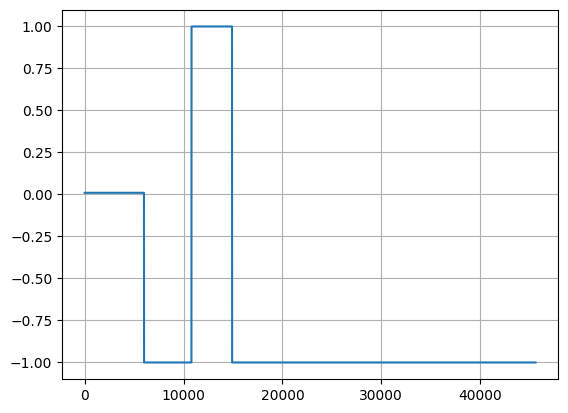

In [4]:
import matplotlib.pyplot as plt  # Corrigindo a importação


env = Env3WGym(valid_data[0][:, 1:-1])

env.reset()
acc_reward = []
for i in range(len(valid_data[0])):

    if valid_data[0][i, -1] == 0:
        action = 0
    else:
        action = 1
    
    obs, reward, done, info = env.step(action)
    acc_reward.append(reward)


# Plto no eixo x o range do valid_data[0] e no eixo y o acc_reward
plt.plot(range(len(valid_data[0])), acc_reward)
plt.grid()
plt.show()

    